In [1]:
import pandas as pd
import numpy as np

In [2]:
from datasets import load_dataset

HF_USERNAME = "LukeGPT88"
PROJECT_NAME = "patient-doctor-text-classifier"
SUB_PROJECT_NAME = "eng"
DATASET_NAME = f"{HF_USERNAME}/{PROJECT_NAME}-{SUB_PROJECT_NAME}-dataset"
TASK = f"{PROJECT_NAME}-{SUB_PROJECT_NAME}"

In [3]:
dataset = load_dataset(DATASET_NAME)

In [4]:
id2label = {0: "PATIENT", 1: "DOCTOR", 2: "NEUTRAL"}

def mapping(idx):
  label = id2label.get(idx)
  return label

## FOR OLD DATASET ONLY (HF repo patient-doctor-text-classifier-eng-dataset-old)

### Convert short texts in neutral conversations

In [ ]:
# label_train_text = list(map(mapping, dataset['train']['Label']))
# label_val_text = list(map(mapping, dataset['validation']['Label']))
# label_test_text = list(map(mapping, dataset['test']['Label']))

In [ ]:
df_train = pd.DataFrame({'Text': dataset['train']['Text'], 'Label': dataset['train']['Label'], 'Encoding': dataset['train']['Encoding'] })
df_val = pd.DataFrame({'Text': dataset['validation']['Text'], 'Label': dataset['validation']['Label'], 'Encoding': dataset['validation']['Encoding'] })
df_test = pd.DataFrame({'Text': dataset['test']['Text'], 'Label': dataset['test']['Label'], 'Encoding': dataset['test']['Encoding'] })

In [ ]:
# df_train.to_csv('df_train_old.csv')
# df_val.to_csv('df_val_old.csv')
# df_test.to_csv('df_test_old.csv')

In [ ]:
SHORT_TEXT_LENGTH = 10
df_train['Short Text'] = [True if len(text) < SHORT_TEXT_LENGTH else False for text in df_train['Text'].values]
df_val['Short Text'] = [True if len(text) < SHORT_TEXT_LENGTH else False for text in df_val['Text'].values]
df_test['Short Text'] = [True if len(text) < SHORT_TEXT_LENGTH else False for text in df_test['Text'].values]

In [ ]:
# df_val['Text'].loc[df_val['Short Text'] == True].to_csv('df_val')

### Train set

In [ ]:
# we need to convert short expressions to be classified as neutral conversions
# matches all the patterns that are similar to the requested word
import re

texts = df_train['Text'].loc[ (df_train['Short Text'] == True) ]
indexes = df_train['Text'].loc[ (df_train['Short Text'] == True) ].index

words = ['uhm', 'ok', 'no', 'uh', 'sure', 'mmm']
text_to_convert = []
rows_to_convert = []
for text, index in list(map(lambda x, y: (x, y), texts,indexes.values)):
  for word in words:

    regex_pattern = r"\W*\w*" + re.escape(word) + r'\W*\w*'

    matches = re.findall(regex_pattern, text, re.IGNORECASE)
    if len(matches) > 0 :
      rows_to_convert.append(index)
      text_to_convert.append([matches[0], index])
print(len(rows_to_convert))
print(len(list(set(rows_to_convert))))
print(text_to_convert)


In [ ]:
df_train.iloc[list(set(rows_to_convert))][df_train['Label'].isin(['DOCTOR'])]

In [ ]:
df_train.iloc[list(set(rows_to_convert)), df_train.columns.get_loc('Label')] = 'NEUTRAL'
df_train.iloc[list(set(rows_to_convert)), df_train.columns.get_loc('Encoding')] = 2

### Validation set

In [ ]:
# we need to convert short expressions to be classified as neutral conversions
# matches all the patterns that are similar to the requested word
import re

texts = df_val['Text'].loc[ (df_val['Short Text'] == True) ]
indexes = df_val['Text'].loc[ (df_val['Short Text'] == True) ].index

words = ['uhm', 'ok', 'no', 'uh', 'sure', 'mmm']
text_to_convert = []
rows_to_convert = []
for text, index in list(map(lambda x, y: (x, y), texts,indexes.values)):
  for word in words:

    regex_pattern = r"\W*\w*" + re.escape(word) + r'\W*\w*'

    matches = re.findall(regex_pattern, text, re.IGNORECASE)
    if len(matches) > 0 :
      rows_to_convert.append(index)
      text_to_convert.append([matches[0], index])
print(len(rows_to_convert))
print(len(list(set(rows_to_convert))))
print(text_to_convert)

In [ ]:
df_val.iloc[list(set(rows_to_convert))][df_val['Label'].isin(['DOCTOR'])]

In [ ]:
df_val.iloc[list(set(rows_to_convert)), df_val.columns.get_loc('Label')] = 'NEUTRAL'
df_val.iloc[list(set(rows_to_convert)), df_val.columns.get_loc('Encoding')] = 2

### test set

In [ ]:
# we need to convert short expressions to be classified as neutral conversions
# matches all the patterns that are similar to the requested word
import re

texts = df_test['Text'].loc[ (df_test['Short Text'] == True) ]
indexes = df_test['Text'].loc[ (df_test['Short Text'] == True) ].index

words = ['uhm', 'ok', 'no', 'uh', 'sure', 'mmm']
text_to_convert = []
rows_to_convert = []
for text, index in list(map(lambda x, y: (x, y), texts,indexes.values)):
  for word in words:

    regex_pattern = r"\W*\w*" + re.escape(word) + r'\W*\w*'

    matches = re.findall(regex_pattern, text, re.IGNORECASE)
    if len(matches) > 0 :
      rows_to_convert.append(index)
      text_to_convert.append([matches[0], index])
print(len(rows_to_convert))
print(len(list(set(rows_to_convert))))
print(text_to_convert)

In [ ]:
df_test.iloc[list(set(rows_to_convert)), df_test.columns.get_loc('Label')] = 'NEUTRAL'
df_test.iloc[list(set(rows_to_convert)), df_test.columns.get_loc('Encoding')] = 2

### Convert Dataframes to CSV files

In [ ]:
df_train.to_csv('df_train.csv')
df_val.to_csv('df_val.csv')
df_test.to_csv('df_test.csv')

## From Pandas Dataframe To The HF Dataset

In [ ]:
df_train.drop('Short Text', axis=1, inplace=True)
df_val.drop('Short Text', axis=1, inplace=True)
df_test.drop('Short Text', axis=1, inplace=True)

In [ ]:
from datasets import Dataset, DatasetDict
new_ds = DatasetDict()

new_ds['train'] = Dataset.from_pandas(df_train)
new_ds['validation'] = Dataset.from_pandas(df_val)
new_ds['test'] = Dataset.from_pandas(df_test)

print(new_ds)

### HF Login & Dataset Push

In [ ]:
from huggingface_hub import notebook_login

notebook_login()

In [ ]:
new_ds

In [ ]:
new_ds.push_to_hub(DATASET_NAME)

## Memory Size For Texts

In [ ]:
import sys

size_in_bytes = []

for text in new_ds['train']['Text']:
  size_in_bytes.append(sys.getsizeof(text) - sys.getsizeof(""))

print(f"Total Size of text strings: {sum(size_in_bytes)} bytes")
print(f"Average Size for each string: {sum(size_in_bytes)/len(new_ds['train']['Text'])} bytes")

## Adding the Classification Score Field

In [5]:
from transformers import pipeline
classifier = pipeline("text-classification", model=f"{HF_USERNAME}/{TASK}", top_k=None)

/home/luca/anaconda3/envs/HF/lib/python3.10/site-packages/torch/cuda/__init__.py:628: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


In [ ]:
pred_score_list = []
for text in dataset['test']['Text']:
  res = classifier(text)
  pred_score_list.append(res[0])

In [ ]:
df_test['Classification Score'] = pred_score_list

In [ ]:
df_train['Classification Score'] = [[{'label': 'PATIENT', 'score': float(0)}, {'label': 'DOCTOR', 'score': float(0)}, {'label': 'NEUTRAL', 'score': float(0)}]] * len(df_train.index)
df_val['Classification Score'] = [[{'label': 'PATIENT', 'score': float(0)}, {'label': 'DOCTOR', 'score': float(0)}, {'label': 'NEUTRAL', 'score': float(0)}]] * len(df_val.index)

## Confusion Matrix

In [6]:
from transformers import pipeline
classifier = pipeline("text-classification", model=f"{HF_USERNAME}/{TASK}")

In [7]:
pred_list = []
for text in dataset['test']['Text']:
  res = classifier(text)
  pred_list.append(res[0]['label'])

In [8]:
true_list = list(map(mapping, dataset['test']['Encoding']))

In [35]:
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Plot a confusion matrix.
# transpose_cm is the confusion matrix transpose, names are the names of the classes.
def plot_confusion_matrix(transpose_cm, names, title='Confusion Matrix', cmap=plt.cm.Oranges):
  for (i, j), label in np.ndenumerate(transpose_cm):
    plt.text(i,j,label.round(4),ha='center',va='center')
  plt.imshow(transpose_cm, interpolation='nearest', cmap=cmap)
  plt.title(title)
  plt.colorbar()
  tick_marks = np.arange(len(names))
  plt.xticks(tick_marks, names, rotation=45)
  plt.yticks(tick_marks, names)
  plt.tight_layout()
  plt.ylabel('True label')
  plt.xlabel('Predicted label')

Confusion Matrix
[[2614    6   31]
 [   4 3509   18]
 [  21   14 2032]]


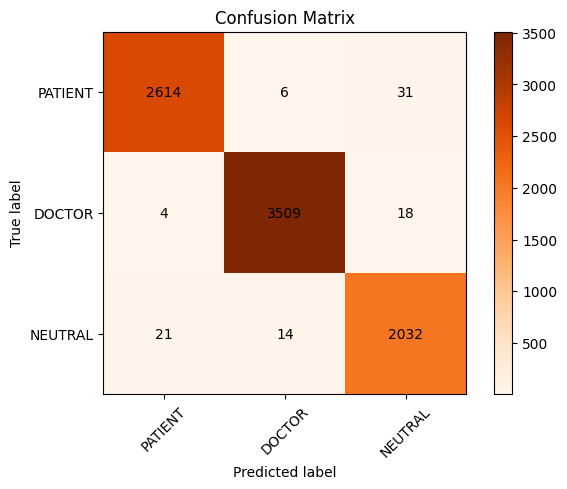

In [36]:
import numpy as np
from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

# Compute confusion matrix
cm = confusion_matrix(true_list, pred_list)
np.set_printoptions(precision=4)
print('Confusion Matrix')
print(cm)
plt.figure()
plot_confusion_matrix(np.transpose(cm), id2label.values(), title='Confusion Matrix')

Normalized Confusion Matrix
[[0.986  0.0023 0.0117]
 [0.0011 0.9938 0.0051]
 [0.0102 0.0068 0.9831]]


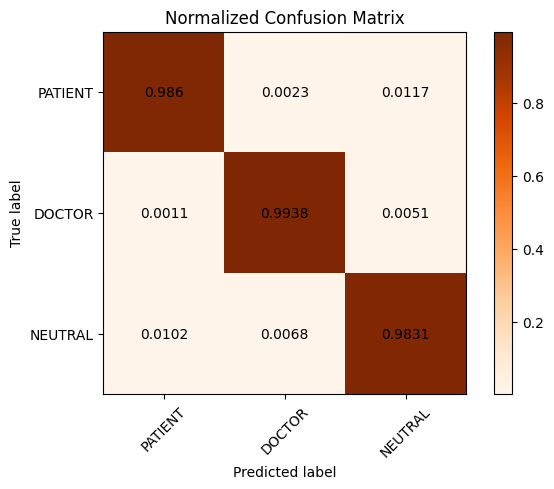

In [37]:
# Normalize the confusion matrix by row (i.e by the number of samples
# in each class)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
print('Normalized Confusion Matrix')
print(cm_normalized)
plt.figure()
plot_confusion_matrix(np.transpose(cm_normalized), id2label.values(), title='Normalized Confusion Matrix')

plt.show()

In [38]:
from sklearn.metrics import precision_recall_fscore_support, accuracy_score

macro = precision_recall_fscore_support(true_list, pred_list, average='macro')
micro = precision_recall_fscore_support(true_list, pred_list, average='micro')
accuracy_score = accuracy_score(true_list, pred_list)
labels_stats = precision_recall_fscore_support(true_list, pred_list, average=None)

print(f'Macro : {macro}\nMicro : {micro}\nAccuracy Score : {accuracy_score}\nLabels Stats : {labels_stats}')

Macro : (0.9871043382910534, 0.9876265734212293, 0.9873600138060667, None)
Micro : (0.9886046793550733, 0.9886046793550733, 0.9886046793550733, None)
Accuracy Score : 0.9886046793550733
Labels Stats : (array([0.9905, 0.9943, 0.9765]), array([0.986 , 0.9938, 0.9831]), array([0.9883, 0.9941, 0.9797]), array([2651, 3531, 2067]))


In [39]:
from sklearn.metrics import classification_report

res = classification_report(true_list, pred_list, target_names=['PATIENT', 'DOCTOR', 'NEUTRAL'])
print(res)

              precision    recall  f1-score   support

     PATIENT       0.99      0.99      0.99      2651
      DOCTOR       0.99      0.99      0.99      3531
     NEUTRAL       0.98      0.98      0.98      2067

    accuracy                           0.99      8249
   macro avg       0.99      0.99      0.99      8249
weighted avg       0.99      0.99      0.99      8249

